# **BBC News Classification Kaggle Mini-Project**

We want to start by importing the necessary libraries. In this notebook, we will use the methodology of Exploratory Data Analysis (EDA).

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


# Part 1. Explanatory Data Analysis

# Step 1.1 Load the Data

In [4]:
# import data, there are three files, i.e. sample solution, test and train
train = pd.read_csv('/kaggle/input/bbc-news/BBC News Train.csv') # 3 columns, i.e., ArticleId, Text and Category, 1490 rows
test=pd.read_csv('/kaggle/input/bbc-news/BBC News Test.csv') # 2 cols, i.e., ArticleId, Text, 735 rows
sol=pd.read_csv('/kaggle/input/bbc-news/BBC News Sample Solution.csv') # 2 cols, i.e. Article, Category, 735 rows

# Step 1.2 Insepct the Data

After inspecting the data, we need to perform some generic processing, i.e. check for null values, etc.

Before we start, like dealing with numeric data, we would like to inspect potential null values and rows that might cause issues, after which we will hit the essence of this step.

In [5]:
# Inspect the data with .info(); since the data is not numeric, I will not use .describe()
print(train.info())
print(test.info())
print(sol.info())

# Use .head() to see the first rows
print(train.head(10))
print(test.head(10))
print(sol.head(10))

# Check for null values
print(train.isnull().sum())
print(test.isnull().sum())
print(sol.isnull().sum())

# It seems that all is good!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
   ArticleI

# Step 1.3 Visualize the Data

In our case, we are dealing with textual data which we desire to categorize. We would like to explore the basic characteristics of the texts, among which, there are word counts and word length.

133


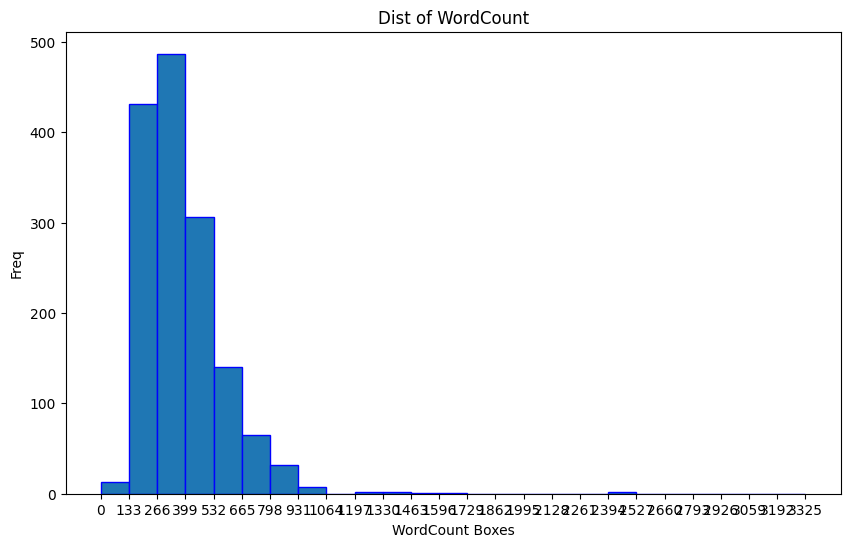

73


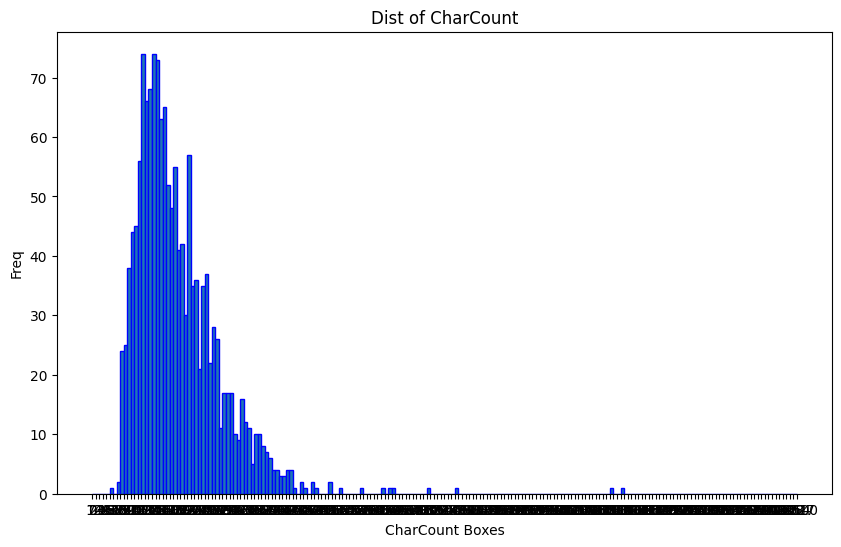

In [6]:

train['WordCount']=train['Text'].apply(lambda x:len(x.split()))
train['AvgWordLength']=train['Text'].apply(lambda x: np.nan_to_num(sum(len(w) for w in x.split())/len(x.split())))
train['CharCount']=train['Text'].apply(lambda x:sum(1 for c in x if c.isalnum()))
#print(train.head(10))
cols=['WordCount','AvgWordLength','CharCount']
div=[25,5,200]
for i in [0,2]:
    plt.figure(figsize=(10, 6))
    print(floor(max(train[cols[i]])/div[i]))
    plt.hist(train[cols[i]], bins=range(0, floor(max(train[cols[i]])) + 1, floor(max(train[cols[i]])/div[i])), edgecolor='blue')
    plt.title('Dist of '+cols[i])
    plt.xlabel(cols[i]+' Boxes')
    plt.ylabel('Freq')
    plt.xticks(range(0, floor(max(train[cols[i]])) + 1, floor(max(train[cols[i]])/div[i])))  # Adjust for clear labels
    plt.show()


# Step 1.4 Feature Engineering

In this step, we need to process the texts so that the machine can treat them. 

To perform the procedure called feature engineering, first of all, it is advisable that the puntuations and stop words are removed, because we assume that they do not contribute much to the categorization learning process. Morever, we need some extra cleaning for the letter cases. Secondly, to rule out the effect from grammar, conjugation and different forms of the same root, we need the process of tokenization and lemmatization. Last but not least, in order that the machine can play with the data and extract the patterns out of it, it is required to convert the texts into numbers, which will allow matrix calculations and machine learning.

In [7]:
print(train.isnull().sum())
print(test.isnull().sum())
print(sol.isnull().sum())

# It seems that everything is good!

print(sol['Category'].unique()) # 5 possibilities,['sport' 'tech' 'business' 'entertainment' 'politics']

# Download the stopwords
#nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# I looked up other people's work to know what libraries to use
# Reference: https://www.kaggle.com/code/dazhengzhu/bbc-news-classification
def Processing(t):
    # Tokenize 
    stemmer=PorterStemmer()
    ws = nltk.word_tokenize(text=t)
    # Filtering words and converting case
    ws=[w.lower() for w in ws if w.isalpha()]
    # Find roots for words that are not stopwords
    sws=set(stopwords.words('english'))
    ws=[stemmer.stem(w) for w in ws if w not in sws]
    return ' '.join(ws)
    
train['ProcessedText']=train['Text'].apply(lambda x:Processing(x))
test['ProcessedText']=test['Text'].apply(lambda x:Processing(x))

#print(train)

ArticleId        0
Text             0
Category         0
WordCount        0
AvgWordLength    0
CharCount        0
dtype: int64
ArticleId    0
Text         0
dtype: int64
ArticleId    0
Category     0
dtype: int64
['sport' 'tech' 'business' 'entertainment' 'politics']
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


# Step 1.5 Data Exploration

(-0.5, 799.5, 399.5, -0.5)

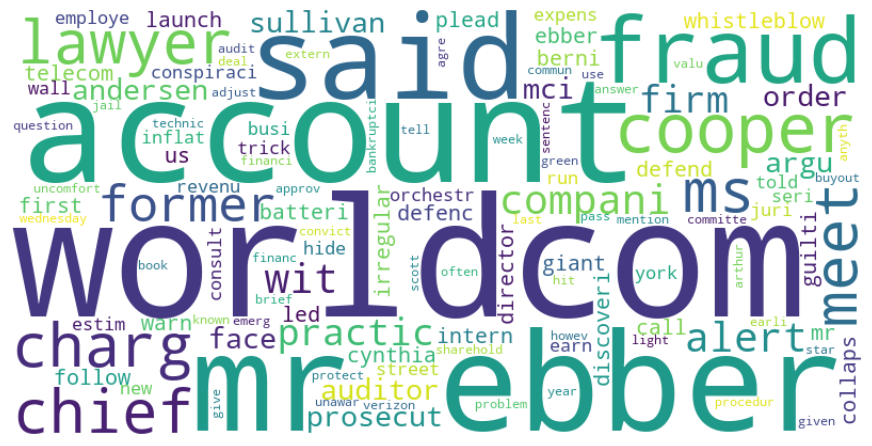

In [7]:
# Reference: https://www.kaggle.com/code/dazhengzhu/bbc-news-classification
# There is a very fun way to visualize the data! I found the library from the link above!
t = train['ProcessedText'][0]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(t)
plt.figure(figsize=(11, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# With this method, we can play with the train and test data!

# **Part 2. Building and Fitting the Model**

In [9]:
# We apply TF-IDF vectorization (Frequency-Inverse Document Frequency)
def TfidfLearning(data,n=5):
    vectorizer = TfidfVectorizer(stop_words='english') # there are many parameters that we can play with though
    tfid_mat = vectorizer.fit_transform(data['ProcessedText'])
    nmf = NMF(n_components=n, random_state=42)
    W = nmf.fit_transform(tfid_mat) # document-topic mat
    H=nmf.components_ # topic-term mat
    return (tfid_mat,vectorizer,nmf,W,H)
    
n = len(sol['Category'].unique()) #5
tfid_mat,vectorizer,nmf,W,H=TfidfLearning(train,n=5)
print(W.shape,H.shape,W,H,test)

# We can manually assign labels by looking at the top words
topics = vectorizer.get_feature_names_out()
m = 15
for i,ws in enumerate(H):
    tops = [topics[i] for i in ws.argsort()[-m:]][::-1] # last 10 words and reverse the order
    print(i,tops)

# After observing the data, we can determine that 0 - technic, 1 - business, 2 - entertainment, 3 - sports, 4 - politics
    
# Alternatively, we can look at all the permutations to find out the permutation that gives the best accuracy
labels=np.array([i for i in range(n)]) # n=5
cats=sol['Category'].unique()
accuracy=0
perm_f=None

# Because to determine the labels, we only need an approximation, assuming that the data are good, we will approximate the
# real category of a text to be the category/topic that has the highest weight in the document-topic matrix
y_pred = np.argmax(W, axis=1)

for perm in list(itertools.permutations(labels)):
    y_true=[perm[np.where(cats==e)[0][0]] for e in train['Category']]
    acc = sum(y_pred==y_true)/len(y_true)
    if acc>accuracy:
        accuracy=acc
        perm_f=perm
    #print(perm,acc)
print("The best accuracy and the best permutation are: ", accuracy,perm_f)

#perm_f=[3,0,1,2,4]
for i in range(len(cats)):
    #print(i,cats[perm_f[i]])
    print(perm_f[i],cats[i])

(1490, 5) (5, 15597) [[0.0125268  0.04112721 0.00428853 0.00140948 0.05205194]
 [0.         0.         0.         0.         0.22080756]
 [0.01276325 0.035466   0.         0.02135053 0.12340545]
 ...
 [0.00153827 0.         0.00629326 0.01593335 0.17232247]
 [0.16922032 0.         0.01010722 0.         0.0181278 ]
 [0.08120491 0.         0.         0.00206446 0.        ]] [[1.45253965e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.56541400e-04 0.00000000e+00]
 [3.48124618e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.60060148e-05 0.00000000e+00]
 [7.41234138e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.05539880e-03 0.00000000e+00]
 [8.71736145e-05 1.10154467e-02 1.09041440e-03 ... 1.05868853e-02
  5.33349653e-04 7.05320745e-03]
 [5.14254852e-04 1.68795973e-04 0.00000000e+00 ... 1.67600363e-04
  5.54970695e-05 0.00000000e+00]]      ArticleId                                               Text  \
0         1018  qpr keeper day heads for preston queens park

We can test this model on test data to see if the result is desirable; if not, we consider making some improvements.

Without supervised learning, just approximating the category by finding maximum the document-topic weight, accuracy for test data: 0.19047619047619047
The MSE for the test data is calculated to be: 3.919727891156463
Confusion Matrix: [[29 35 35 26 22]
 [39 24 30 29 25]
 [30 34 34 30 19]
 [34 25 41 31 16]
 [37 26 33 29 22]]


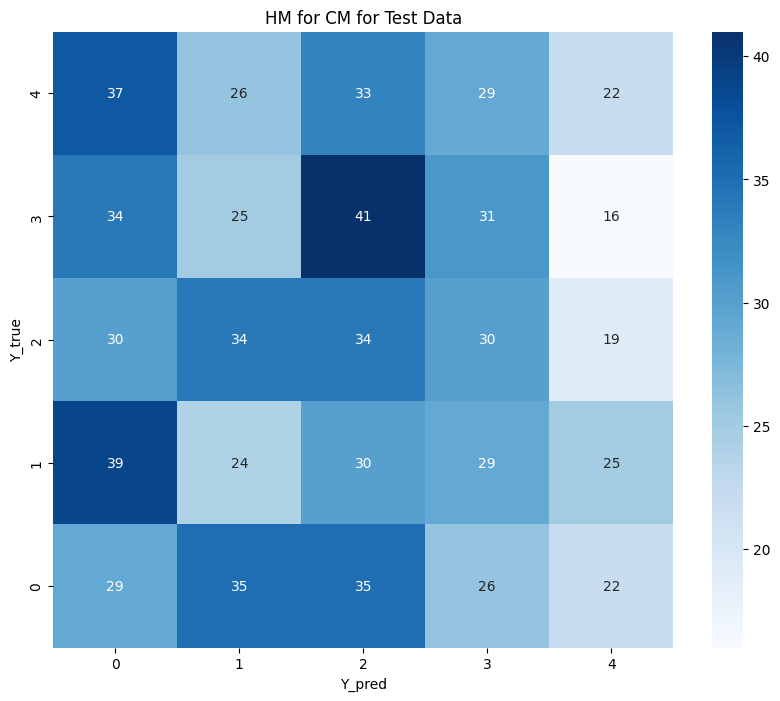

In [10]:
test_sol = pd.merge(test, sol, on='ArticleId', how='left') 
tfid_mat_test= vectorizer.transform(test_sol['ProcessedText'])
W_test=nmf.fit_transform(tfid_mat_test) 
y_pred_test = np.argmax(W_test, axis=1)
y_true_test= np.array([perm_f[np.where(cats==e)[0][0]] for e in test_sol['Category']])
acc = sum(y_pred_test==y_true_test)/len(y_true_test)
print("Without supervised learning, just approximating the category by finding maximum the document-topic weight, accuracy for test data:",acc)

from sklearn.metrics import mean_squared_error, confusion_matrix
mse = mean_squared_error(y_true_test, y_pred_test)
cm = confusion_matrix(y_true_test, y_pred_test)
print(f"The MSE for the test data is calculated to be: {mse}")
print("Confusion Matrix:",cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.gca().invert_yaxis()
plt.title('HM for CM for Test Data')
plt.xlabel('Y_pred')
plt.ylabel('Y_true')
plt.show()



As expected the result is poor due to many limitations of NMF. Now we consider adjusting the hyperparameters to improve the model.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
vec = TfidfVectorizer()
nmf = NMF()

# Set the hyperparameter grid
grid = {
    'vectorizer__max_df': [0.9, 0.95, 1.0],
    'vectorizer__min_df': [1, 2, 5],
    'nmf__init': ['random', 'nndsvd'],
}
pipeline = Pipeline([
    ('vectorizer', vec),
    ('nmf', nmf)
])
# The code takes too much time, so it is not recommended to run them
# gridSearch = GridSearchCV(pipeline, grid, cv=5, scoring='neg_mean_squared_error')
# gridSearch.fit(train['ProcessedText'], y_true)

# Best parameters and score
# print("The best parameters for vectorization and matrix factorization are:", gridSearch.best_params_)
# print("The corresponding mean squared error:", -gridSearch.best_score_)

# Let's just use the default param instead

Now that we have the best parameters, we will use them for our further investigations.

# **Part 3 Model Evaluation and Comparison with Supervised Learning**

From Part 2, we From Part 2, we can know the mapping of numeric labels and the categories as follows:
* 3 sport
* 0 tech
* 4 business
* 2 entertainment
* 1 politics

With this information, we can further perform supervised learning mechanisms such as logistic regression, in order to compare the results of unsupervised learning and those of supervised learning.

In [11]:

# Now we can try random forest
rf = RandomForestClassifier(random_state=42)
rf.fit(W, y_true)

y_pred = rf.predict(W)
acc = accuracy_score(y_pred, y_true)
print(f"Accuracy for train data: {acc}")

y_pred_test = rf.predict(W_test)
acc_test = accuracy_score(y_pred_test, y_true_test)
print(f"Accuracy for test data: {acc_test}")

# Now we will use Logistic Regression
model_log=LogisticRegression()    
model_log.fit(W, y_true)

y_pred = model_log.predict(W)
acc = accuracy_score(y_pred, y_true)
print(f"Accuracy for train data: {acc}")

y_pred_test = model_log.predict(W_test)
acc_test = accuracy_score(y_pred_test, y_true_test)
print(f"Accuracy for test data: {acc_test}")

# Linear SVC
svc = SVC(kernel='linear', random_state=42)
svc=svc.fit(W, y_true)
y_pred = svc.predict(W)
acc = accuracy_score(y_pred, y_true)
print(f"Accuracy for train data: {acc}")

y_pred_test = svc.predict(W_test)
acc_test = accuracy_score(y_pred_test, y_true_test)
print(f"Accuracy for test data: {acc_test}")


# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(W, y_true)
y_pred = knn.predict(W)
acc = accuracy_score(y_pred, y_true)
print(f"Accuracy for train data: {acc}")

y_pred_test = knn.predict(W_test)
acc_test = accuracy_score(y_pred_test, y_true_test)
print(f"Accuracy for test data: {acc_test}")


# Naive Bayes
nb = MultinomialNB()
nb.fit(W, y_true)
y_pred = nb.predict(W)
acc = accuracy_score(y_pred, y_true)
print(f"Accuracy for train data: {acc}")

y_pred_test = nb.predict(W_test)
acc_test = accuracy_score(y_pred_test, y_true_test)
print(f"Accuracy for test data: {acc_test}")

Accuracy for train data: 1.0
Accuracy for test data: 0.20952380952380953
Accuracy for train data: 0.8993288590604027
Accuracy for test data: 0.19591836734693877
Accuracy for train data: 0.9
Accuracy for test data: 0.19863945578231293
Accuracy for train data: 0.9523489932885906
Accuracy for test data: 0.2108843537414966
Accuracy for train data: 0.6516778523489933
Accuracy for test data: 0.18775510204081633


We can also check if the data size can affect the accuracies by varying the data sizes and redo the tests above.

In [12]:
for pc in [0.2,0.5,0.7,0.9,1]:
    print("Now we are traing the model for this portion of training data: ",pc)
    tfid_mat,vectorizer,nmf,W,H=TfidfLearning(train[:floor(len(train)*pc)],n=5)
    y_true= np.array([perm_f[np.where(cats==e)[0][0]] for e in train[:floor(len(train)*pc)]['Category']])

    test_sol = pd.merge(test, sol, on='ArticleId', how='left') 
    tfid_mat_test= vectorizer.transform(test_sol['ProcessedText'])
    W_test=nmf.fit_transform(tfid_mat_test) 
    y_pred_test = np.argmax(W_test, axis=1)
    y_true_test= np.array([perm_f[np.where(cats==e)[0][0]] for e in test_sol['Category']])
    #acc = sum(y_pred_test==y_true_test)/len(y_true_test)
    #print("Without supervised learning, just approximating the category by finding maximum the document-topic weight, accuracy for test data:",acc)

    # Now we can try random forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(W, y_true)

    y_pred = rf.predict(W)
    acc = accuracy_score(y_pred, y_true)
    print(f"Accuracy for train data: {acc}")

    y_pred_test = rf.predict(W_test)
    acc_test = accuracy_score(y_pred_test, y_true_test)
    print(f"Accuracy for test data: {acc_test}")

    # Now we will use Logistic Regression
    model_log=LogisticRegression()    
    model_log.fit(W, y_true)

    y_pred = model_log.predict(W)
    acc = accuracy_score(y_pred, y_true)
    print(f"Accuracy for train data: {acc}")

    y_pred_test = model_log.predict(W_test)
    acc_test = accuracy_score(y_pred_test, y_true_test)
    print(f"Accuracy for test data: {acc_test}")

    # Linear SVC
    svc = SVC(kernel='linear', random_state=42)
    svc=svc.fit(W, y_true)
    y_pred = svc.predict(W)
    acc = accuracy_score(y_pred, y_true)
    print(f"Accuracy for train data: {acc}")

    y_pred_test = svc.predict(W_test)
    acc_test = accuracy_score(y_pred_test, y_true_test)
    print(f"Accuracy for test data: {acc_test}")


    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(W, y_true)
    y_pred = knn.predict(W)
    acc = accuracy_score(y_pred, y_true)
    print(f"Accuracy for train data: {acc}")

    y_pred_test = knn.predict(W_test)
    acc_test = accuracy_score(y_pred_test, y_true_test)
    print(f"Accuracy for test data: {acc_test}")


    # Naive Bayes
    nb = MultinomialNB()
    nb.fit(W, y_true)
    y_pred = nb.predict(W)
    acc = accuracy_score(y_pred, y_true)
    print(f"Accuracy for train data: {acc}")

    y_pred_test = nb.predict(W_test)
    acc_test = accuracy_score(y_pred_test, y_true_test)
    print(f"Accuracy for test data: {acc_test}")

Now we are traing the model for this portion of training data:  0.2
Accuracy for train data: 1.0
Accuracy for test data: 0.1891156462585034
Accuracy for train data: 0.8590604026845637
Accuracy for test data: 0.18095238095238095
Accuracy for train data: 0.8691275167785235
Accuracy for test data: 0.17687074829931973
Accuracy for train data: 0.9362416107382551
Accuracy for test data: 0.19319727891156463
Accuracy for train data: 0.5604026845637584
Accuracy for test data: 0.19591836734693877
Now we are traing the model for this portion of training data:  0.5
Accuracy for train data: 1.0
Accuracy for test data: 0.1891156462585034
Accuracy for train data: 0.8751677852348994
Accuracy for test data: 0.19319727891156463
Accuracy for train data: 0.8617449664429531
Accuracy for test data: 0.18639455782312925
Accuracy for train data: 0.9516778523489933
Accuracy for test data: 0.18775510204081633
Accuracy for train data: 0.6187919463087248
Accuracy for test data: 0.20272108843537415
Now we are train

# **Conclusion**

There are two observations from the results:
1. The size of training data does not have a significant impact on the accuracies
1. Among the supervised learning mechanisms, KNN seems to yield the best result for the test data, whilst Naive Bayes is the worst. 
1. In general, even if a model can fit the training data well, the prediction for new data can be poor, which indicates that some improvements might need to be done on the model and more data might be needed. This is understandable, since we use use a small fraction of the data to train the models, which definitely leads to huge bias and uncertainty. For future reference, in order to make the model work, first and foremost, we need to increase the data size and combine the strategy of Tfidf and the KNN mechanism.